# Co-Simulation: A real world example

1. We translate/synthesize a design and output Verilog at different stages:
   1. Before mapping to a Technology
   2. After mapping to a specific FPGA technology (ECP5)
2. We verify the functional MyHDL model against the synthesized output

## Synthesis stage

We try to synthesize our [synchronous test logic](sync_logic.ipynb) and display the result as follows.

### Creating the synchronous XOR logic

In [2]:
from myhdl import *

@block
def test(clk, a, b):
    @always(clk.posedge)
    def xor_assign():
        b.next = a ^ 0xaa

    return instances()

## Translating

In [1]:
import config


In [3]:
TECHLIBS_PATH = "/usr/share/yosys"
YOSYS_ABC_EXE = "/usr/bin/yosys-abc"

from myhdl.conversion import yshelper
from ys_aux import to_svg

def convert():
    clk = Signal(bool())
    v, q = [ Signal(intbv()[8:]) for i in range(2) ]

    design = yshelper.Design("test")
    inst = test(clk, v, q)
    inst.convert("yosys_module", design, name="test", trace=True)
    return design

design = convert()

CREATE Module: 'test'
Adding module with name: test_1_8_8
CONVERT_RTL tree >>>>>> 'TEST_XOR_ASSIGN' 
DONE instancing submodules


## Schematic procedure

The configuration variable `SYNTHESIZE_TEST` determines the synthesis stage being run.
You might want to run the entire sheet again after setting this to `True`.

In [4]:
SYNTHESIZE_TEST = False

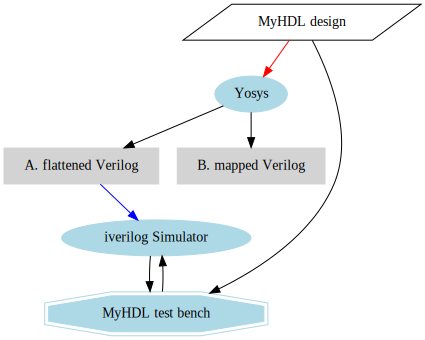

In [5]:
from graphviz import Digraph

dot = Digraph("Schematic")
dot.attr('node', shape='parallelogram')

dot.node('A', 'MyHDL design' ); 
dot.attr('node', shape='box', style='filled', color='lightgrey')
dot.node('p', "A. flattened Verilog")
dot.node('m', "B. mapped Verilog")

dot.attr('node', shape='ellipse', color='lightblue')
dot.node('Y', 'Yosys' );  dot.node('I', 'iverilog Simulator')
dot.attr('node', shape='doubleoctagon')

dot.node('T', 'MyHDL test bench');
dot.edges(['AT', 'Ym', 'Yp', 'TI', 'IT'])
if SYNTHESIZE_TEST:
    dot.attr('node', shape='parallelogram', color='lightyellow')
    dot.node('V', 'Vendor Models')
    dot.edge('m', 'I', color='blue')
    dot.edge('V', 'I', color='blue')
else:
    dot.edge('p', 'I', color='blue')

dot.edge('A', 'Y', color='red')

dot

## (Conditional) Synthesizing/Mapping

In [6]:
design = convert()
if SYNTHESIZE_TEST: # Run synthesis commands
    commands = [ "read_verilog -lib -specify %s/ecp5/cells_sim.v %s/ecp5/cells_bb.v" % (TECHLIBS_PATH, TECHLIBS_PATH) ]
    commands += ["hierarchy -check"]
    commands += [ "proc", "flatten", "tribuf -logic", "deminout", "opt_expr", "debug opt_clean"]
    commands += [ "techmap -map %s/cmp2lut.v -D LUT_WIDTH=4" % TECHLIBS_PATH ]
    commands += [ "opt_expr", "opt_clean" ]
    commands += [ "techmap -map %s/techmap.v -map %s/ecp5/arith_map.v" % (TECHLIBS_PATH, TECHLIBS_PATH) ]
    commands += [ "techmap -map %s/ecp5/cells_map.v" % TECHLIBS_PATH ]
    commands += [ "opt_lut_ins -tech ecp5", "clean" ]

    design.run(commands)  # important to resolve

CREATE Module: 'test'
Adding module with name: test_1_8_8
CONVERT_RTL tree >>>>>> 'TEST_XOR_ASSIGN' 
DONE instancing submodules


Generating RTL image...
Display...


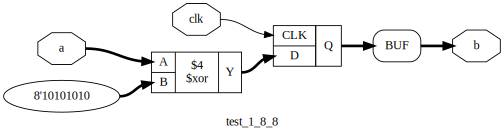

In [7]:
display(to_svg(design, "", 75))

Now we emit the design in Verilog:

In [8]:
design.write_verilog("test", rename_default=True, rename_signals=True)

We then create a wrapper for a Co-Simulation object that is making use of the just emitted Verilog file, using a Co-Simulation auxiliary.

## Co-Simulation module (object)

In [9]:
from ys_aux import setupCosimulation

# Extra files (vendor specific) used for primitive simulation:
_t = TECHLIBS_PATH + '/ecp5/'
simulation_files = [ _t + "cells_sim.v", _t + "cells_bb.v" ]

@block
def unit_verilog_wrapper(clk, a, b):
    "Wrapper for cosimulation object"
    args = locals()
    name = "test_mapped"
    return setupCosimulation(name, use_assert=False, interface=args, debug=True, extra_files = simulation_files)

We take the setup from our previous example and modify it using a `unit` parameter, allowing to pass a different implementation.

In [11]:
@block
def testbench(unit):
    clk = Signal(bool())
    a, b, z = [ Signal(intbv(0xff)[8:]) for i in range(3) ]
    # Create instance of unit under test:
    uut_inst = unit(clk, a, b)
    
    @instance
    def stimulus():
        VALUES = [ 0xaa, 0xab, 0x55, 0x00, 0x00 ]

        yield (clk.posedge);  yield (clk.posedge)
        print("a  b")
        for v in VALUES:
            yield clk.negedge
            a.next = v
            z.next = a
            yield clk.posedge
            print(z, b)
        yield clk.posedge
        raise StopSimulation

    @always(delay(10))
    def clkgen():
        clk.next = not clk

    return instances()

Run Simulation for both implementations:

In [12]:
for uut in test, unit_verilog_wrapper:
    print(20*'-')
    tb = testbench(uut)
    tb.config_sim(backend = 'myhdl', timescale="1ps", trace=True, tracebackup=False)
    tb.run_sim()
    tb.quit_sim() # Quit so we can run another one

--------------------
a  b
ff 55
aa 00
ab 01
55 ff
00 aa
--------------------
Analyze command: iverilog -g2012 -o test_mapped.o test_mapped.v tb_test_mapped.v /usr/share/yosys/ecp5/cells_sim.v /usr/share/yosys/ecp5/cells_bb.v
Simulation command: vvp -m /home/pyosys/src/myhdl/myhdl-yosys/cosimulation/icarus/myhdl.vpi test_mapped.o
a  b
ff 55
aa 00
ab 01
55 ff
00 aa


### Verilog model waveform

A `test.vcd` wavefile was created by the iverilog simulator.
Likewise, the MyHDL simulation created a `testbench.vcd`

In [13]:
import wavedraw
import nbwavedrom

TB = "tb_test.dut"
ECP5_WAVE_CONFIG = { TB + '.a[7:0]' : None, TB + '.b[7:0]' : None }
waveform = wavedraw.vcd2wave("test.vcd", TB + '.clk', cfg = ECP5_WAVE_CONFIG)    
nbwavedrom.draw(waveform)

In [14]:
nbwavedrom.draw(wavedraw.vcd2wave("testbench.vcd", 'testbench.clk', None))

## Observations

* MyHDL simulation limitations: No awareness of uninitialized/undefined signal states ('U' or 'X' from VHDL **std_logic** package)
* MyHDL simulator always assumes initialized values
* For true verification, we must rely on proper Co-Simulation or external Verilog simulation

## Exercise

1. Enable `SYNTHESIZE_TEST_ECP` at the [Schematic procedure](#/slide-3-0) paragraph
1. Change the [synthesis script](#Synthesis-stage) such that it runs a particular synthesis process, for instance, creating a LUT from the logic description
2. Create a RTL display visualizing the generated logic entities
2. Re-run the Co-Simulation using these entities

### Next: [Black boxes](blackbox.ipynb)